In [56]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_features = pd.read_csv('training_set_features.csv')
test_features = pd.read_csv('test_set_features.csv')
train_labels = pd.read_csv('training_set_labels.csv')

In [3]:
train_features.shape

(26707, 36)

In [4]:
train_labels.shape

(26707, 3)

In [5]:
test_features.shape

(26708, 36)

In [10]:
train_data = pd.merge(train_features, train_labels, on='respondent_id')

In [11]:
target_columns = ['xyz_vaccine', 'seasonal_vaccine']
X = train_data.drop(columns=['respondent_id'] + target_columns)
y = train_data[target_columns]

In [13]:
categorical_cols=train_data.select_dtypes(include=['object']).columns
ordinal_cols = ['xyz_concern', 'xyz_knowledge', 'opinion_xyz_vacc_effective', 'opinion_xyz_risk',
                'opinion_xyz_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
                'opinion_seas_sick_from_vacc']
binary_cols = ['behavioral_antiviral_meds','behavioral_avoidance','behavioral_face_mask','behavioral_wash_hands',
             'behavioral_large_gatherings','behavioral_outside_home','behavioral_touch_face','doctor_recc_xyz',
             'doctor_recc_seasonal','chronic_med_condition','child_under_6_months','health_worker','health_insurance']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
y_test1 = y_test['xyz_vaccine']
y_test2 = y_test['seasonal_vaccine']

In [45]:
y_train1 = y_train['xyz_vaccine']
y_train2 = y_train['seasonal_vaccine']

<Axes: >

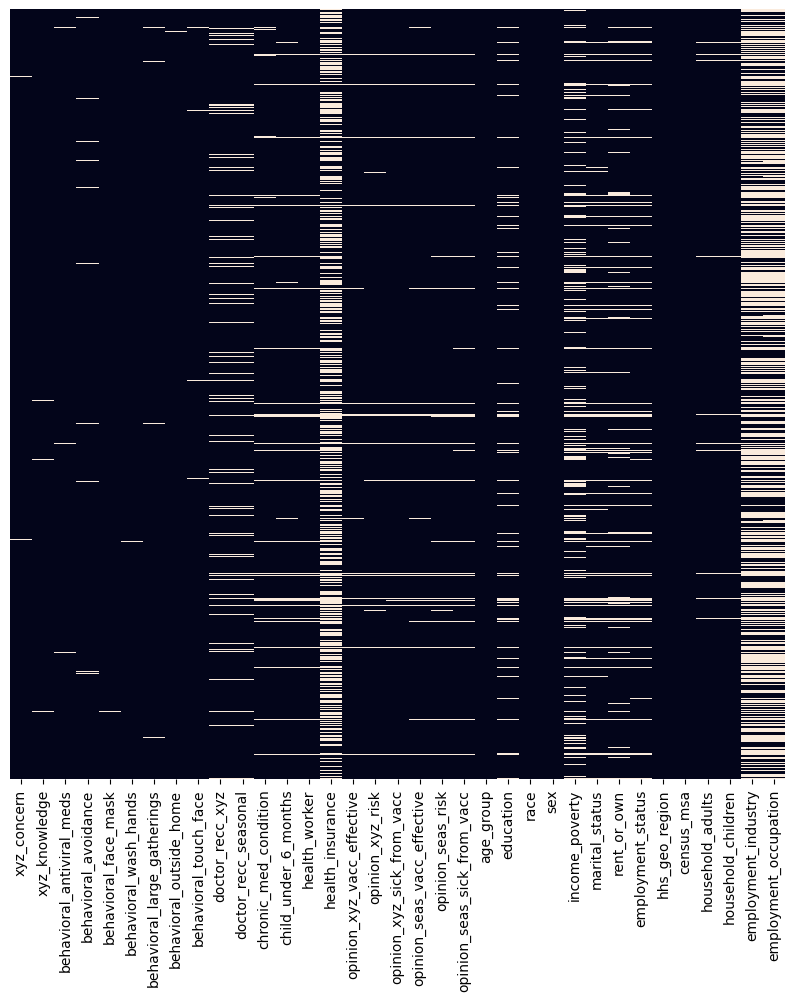

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(X.isnull(),yticklabels=False,cbar=False)

In [17]:
transform = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), binary_cols + ordinal_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

In [18]:
logistic = LogisticRegression(max_iter=2500, random_state=42)

In [19]:
pipeline=Pipeline(steps=[
    ('transform', transform),
    ('scaler', StandardScaler()),
    ('classifier', logistic)
])

In [22]:
pipeline.fit(X_train, y_train1)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_xyz',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'chil...
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=2500, random_state=42))])

In [23]:
pipeline.fit(X_train, y_train2)

Pipeline(steps=[('transform',
                 ColumnTransformer(transformers=[('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'behavioral_touch_face',
                                                   'doctor_recc_xyz',
                                                   'doctor_recc_seasonal',
                                                   'chronic_med_condition',
                                                   'chil...
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation'],
      dtype='object'))])),
                ('scaler', StandardScaler()),
                ('classifier',
                 LogisticRegression(max_iter=2500, random_state=42))])

In [48]:
y_xyz = pipeline.predict(X_test)
y_seasonal = pipeline.predict(X_test)

In [50]:
roc_auc_xyz = roc_auc_score(y_test1, y_xyz)
roc_auc_seasonal = roc_auc_score(y_test2, y_seasonal)
mean_roc_auc = (roc_auc_xyz + roc_auc_seasonal) / 2

In [51]:
print(f"ROC AUC for xyz_vaccine: {roc_auc_xyz}")
print(f"ROC AUC for seasonal_vaccine: {roc_auc_seasonal}")
print(f"Mean ROC AUC: {mean_roc_auc}")

ROC AUC for xyz_vaccine: 0.6582316432611418
ROC AUC for seasonal_vaccine: 0.784624436252521
Mean ROC AUC: 0.7214280397568313


In [27]:
for_pred = test_features.drop(columns=['respondent_id'])

In [52]:
xyz_pred = pipeline.predict_proba(for_pred)[:,0]
seasonal_pred = pipeline.predict_proba(for_pred)[:,1]

In [53]:
submission1 = pd.DataFrame({
    'respondent_id': test_features['respondent_id'],
    'xyz_vaccine': xyz_pred,
    'seasonal_vaccine': seasonal_pred
})

In [55]:
submission1.to_csv('submission1.csv', index=False)